# Transformer for Generation of music using VQVAE outputs

## Imports

In [1]:
try: 
    import librosa
except:
    !pip install librosa
try: 
    import optuna, plotly
except:
    !pip install optuna
    !pip install plotly


#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))

# Torch
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn.functional as F
import optuna, plotly
from optuna.importance import get_param_importances
from optuna.visualization import plot_param_importances
from transformers import get_linear_schedule_with_warmup
from collections import Counter
# Utils
import numpy as np
from numpy import ndarray
import logging, math


# Base Scripts
from Libraries.Utils import *
from Libraries.VQ_VAE import *
from Libraries.Transformer import *

## Setup

### Initial Setup

In [2]:
remote_kernel: bool = True
device: str = "cuda" if torch.cuda.is_available() else "cpu"
training_data_name: str = "../Data/training_v2_full"
test_data_name: str = "../Data/unseen_test_data.npy"
vq_vae_name: str = "VQ_VAE_v2"
vq_vae_path: str = OS().path_to_remote_path("../Models/{}".format(vq_vae_name), remote_kernel)
model_name: str = "transformer_v2_2"
full_model_path: str = OS().path_to_remote_path("../Models/{}".format(model_name), remote_kernel)

### Logging

In [3]:
logging_level: int = logging.INFO
logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)

### Data Hyperparameters

In [4]:
batch_size: int = 16
n_workers: int = 1

### Load VQ VAE

In [5]:
vq_vae = VQVAE(input_emb_width=1, output_emb_width=64, k_bins=2048, levels=1, downs_t=[3], strides_t=[2]).to(device)

In [6]:
if os.path.exists(vq_vae_path):
    model = torch.load(vq_vae_path, map_location=device)
    vq_vae.load_state_dict(model["vq_vae"])
    logger.info(f"Model {vq_vae_name} loaded with {count_parameters(vq_vae)} Parameters")

2025-08-11 13:08:24,693 - INFO - Model VQ_VAE_v2 loaded with ~597.5k Parameters


### Data loading

In [7]:
md = ModelData()
md.load_data_from_path(data_path=OS().path_to_remote_path(training_data_name, remote_kernel))
md.create_validation_split()
train_dataset, val_dataset  = md.create_datasets()
logger.info(f"Created train dataset with length {len(md.train_dataset)} and validation dataset with length {len(md.val_dataset)}")
del md

2025-08-11 13:08:45,128 - INFO - Created train dataset with length 4267 and validation dataset with length 224


In [8]:
md = ModelData()
md.load_data_from_path(data_path=OS().path_to_remote_path(test_data_name, remote_kernel))
md.create_validation_split()
test_dataset, _ = md.create_datasets()
test_dataloader, _ = md.create_dataloaders(batch_size, num_workers=n_workers)
logger.info(f"Created test dataset with length {len(md.train_dataset)}")

2025-08-11 13:08:46,258 - INFO - Created test dataset with length 268


In [9]:
def generate_latent_repr(vq_vae: VQVAE, data: Dataset, batch_size: int = 24, device: str = "cpu", n_samples: int | None = None) -> Dataset:
    data_loader = DataLoader(data, batch_size=batch_size, shuffle=False)
    converted_data = []
    vq_vae.eval()
    for b,_ in (data_loader):
        with torch.no_grad():
            indicies = vq_vae.encode(b.unsqueeze(1).to(device))
        converted_data.append(indicies)
    vq_vae.train()
    new_data = torch.cat(converted_data, dim=0)
    if n_samples is not None:
        new_data = new_data[:n_samples, ...]
    
    return AudioDataset(new_data, data_type=torch.long)

In [10]:
latent_dataset = generate_latent_repr(vq_vae, train_dataset, 24, device)
latent_val_dataset = generate_latent_repr(vq_vae, val_dataset, 24, device)
train_dataloader = DataLoader(latent_dataset, batch_size, shuffle=False)
validation_dataloader = DataLoader(latent_val_dataset, batch_size, shuffle=False)


tensor([1001, 1126,  698,  ...,  402,  313, 1731], device='cuda:0')
tensor([1943, 1013, 1414,  ..., 1009,  576, 1811])


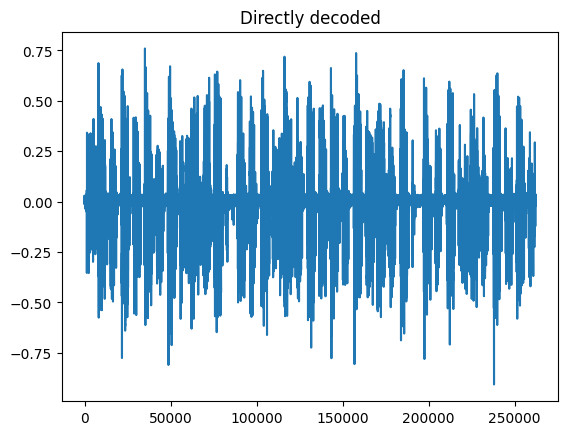

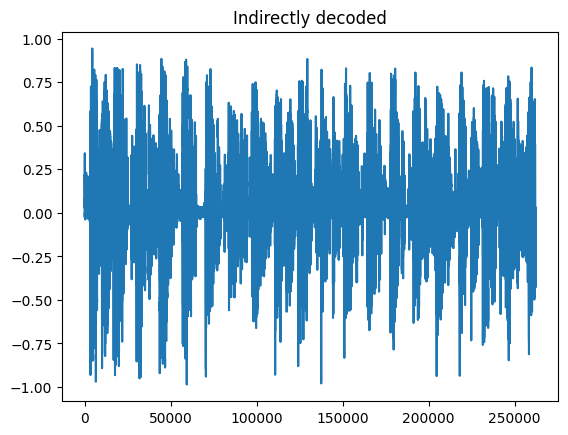

tensor([1568,  454, 1391,  ..., 1993, 1993, 1993], device='cuda:0')
tensor([1568, 1371,   46,  ...,   26,  517,  223])


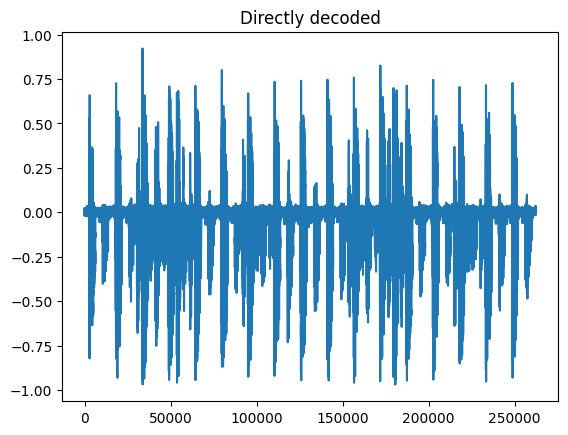

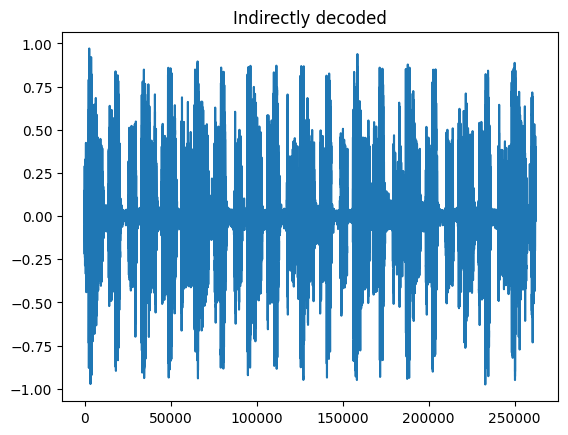

In [11]:

vq_vae.eval()
inp = train_dataset[:24][0].unsqueeze(1).to(device)
with torch.no_grad():
    output, q_z, commit_loss, metrics = vq_vae(inp)
    outp = vq_vae.decode(latent_val_dataset[:24][0].to(device))

for idx in range(2):
    print(q_z[idx])
    print(latent_val_dataset[idx][0])
    plt.plot(output[idx][0].cpu().numpy())
    plt.title("Directly decoded")
    plt.show()
    plt.plot(outp[idx][0].cpu().numpy())
    plt.title("Indirectly decoded")
    plt.show()

In [12]:
latent_test_dataset = generate_latent_repr(vq_vae, test_dataset, 12, device)
latent_test_dataloader = DataLoader(latent_test_dataset, batch_size, shuffle=False)

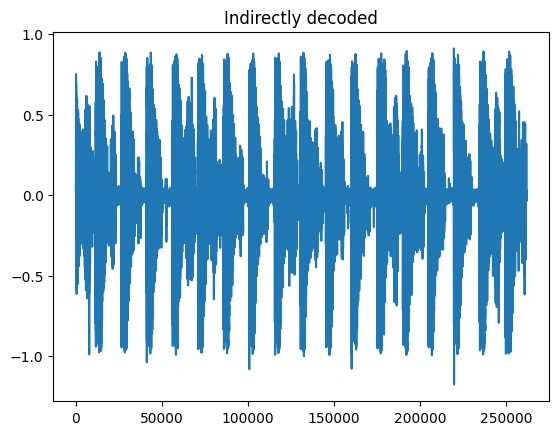

In [13]:
vq_vae.eval()
with torch.no_grad():
    outp = vq_vae.decode(latent_test_dataset[:24][0].to(device))

plt.plot(outp[4][0].cpu().numpy())
plt.title("Indirectly decoded")
plt.show()

In [14]:
all_tokens = torch.cat([x.flatten() for x, _ in train_dataloader]).tolist()
token_counts = Counter(all_tokens)

## Model Setup

### Hyperparameters

In [15]:
b1, b2 = (0.9, 0.95)
lr = 2e-4
n_epochs = 100 
restart_training: bool = True
training_seq_len: int = 2048
checkpoint_freq: int = 10

### Models

In [16]:
transformer = TransformerDec(vocab_size=2048, embed_size=1024, n_layers=6, forward_expansion=4, n_heads=8, pad_idx=-1, dropout=0.3, device=device, max_seq_len=2048).to(device)

In [17]:
class CausalSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout):
        super().__init__()
        assert embed_dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv_proj = nn.Linear(embed_dim, 3 * embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attn_mask=None):
        B, T, C = x.size()
        qkv = self.qkv_proj(x).view(B, T, self.num_heads, 3 * self.head_dim)
        q, k, v = qkv.chunk(3, dim=-1)  # Each: [B, T, n_heads, head_dim]

        q = q.transpose(1, 2)  # [B, n_heads, T, head_dim]
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        attn_scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)  # [B, n_heads, T, T]
        if attn_mask is not None:
            attn_scores = attn_scores.masked_fill(attn_mask == 0, float('-inf'))
        attn = F.softmax(attn_scores, dim=-1)
        attn = self.dropout(attn)

        out = (attn @ v).transpose(1, 2).contiguous().view(B, T, C)
        return self.out_proj(out)

class GPTBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_mult=4, dropout=0.1):
        super().__init__()
        self.attn = CausalSelfAttention(embed_dim, num_heads, dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_mult * embed_dim),
            nn.GELU(),
            nn.Linear(ff_mult * embed_dim, embed_dim),
            nn.Dropout(dropout)
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x, mask=None):
        x = x + self.attn(self.norm1(x), attn_mask=mask)
        x = x + self.ff(self.norm2(x))
        return x

class GPTDecoder(nn.Module):
    def __init__(self, vocab_size=2048, max_seq_len=2048, embed_dim=512, num_heads=8, num_layers=6, dropout=0.1):
        super().__init__()
        self.max_seq_len = max_seq_len
        self.token_embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_embed = nn.Parameter(torch.zeros(1, max_seq_len, embed_dim))
        self.drop = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([
            GPTBlock(embed_dim, num_heads, dropout=dropout)
            for _ in range(num_layers)
        ])
        self.ln_f = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, vocab_size)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx):
        B, T = idx.size()
        token_embeddings = self.token_embed(idx)
        pos_embeddings = self.pos_embed[:, :T, :]
        x = self.drop(token_embeddings + pos_embeddings)

        # Causal mask: [1, 1, T, T] for broadcasting over batch/head
        mask = torch.tril(torch.ones(T, T, device=idx.device)).unsqueeze(0).unsqueeze(0)

        for block in self.blocks:
            x = block(x, mask=mask)

        x = self.ln_f(x)
        return self.head(x)


In [18]:
transformer = GPTDecoder().to(device)

### Optimizers & Schedulers

In [19]:
optimizer = optim.AdamW(transformer.parameters(), lr, (b1, b2), weight_decay=0.1)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=10000, num_training_steps=n_epochs * len(train_dataloader), last_epoch=-1)

### Model Loading

In [20]:
if os.path.exists(full_model_path):
    model = torch.load(full_model_path, map_location=device)
    transformer.load_state_dict(model["transformer"])

    if not restart_training:
        optimizer.load_state_dict(model["optim"])
        start_epoch = model.get("epoch", 0)
    logger.info(f"Model {model_name} loaded with {count_parameters(transformer)} Parameters")
else: 
    logger.info(f"Model {model_name} created with {count_parameters(transformer)} Parameters")

2025-08-11 13:09:48,461 - INFO - Model transformer_v2_2 created with ~22.06M Parameters


## Training

In [21]:
class SyntheticDataset(Dataset):
    def __init__(self, num_sequences=1000, seq_len=32768, vocab_size=2048, period=10):
        self.num_sequences = num_sequences
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.period = period
        self.data = self._generate_data()

    def _generate_data(self):
        # Generate periodic sequences: [0, 1, 2, ..., period-1, 0, 1, ...]
        pattern = torch.arange(self.period) % self.vocab_size
        sequences = pattern.repeat(self.seq_len // self.period + 1)[:self.seq_len]
        data = sequences.repeat(self.num_sequences, 1)  # [num_sequences, seq_len]
        # Add slight noise to mimic variability
        noise_mask = torch.rand(self.num_sequences, self.seq_len) < 0.05  # 5% noise
        random_tokens = torch.randint(0, self.vocab_size, (self.num_sequences, self.seq_len))
        data = torch.where(noise_mask, random_tokens, data)
        return data.to(torch.long)

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx):
        return self.data[idx], 0  # Dummy label

#train_dataset = SyntheticDataset(num_sequences=800, seq_len=32768, vocab_size=2048, period=10)
#train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [22]:
torch.backends.cudnn.benchmark = True
loss_fn = nn.CrossEntropyLoss(ignore_index=-1)

In [ ]:
logger.info(f"Training started on {device}")
loss_list: list = []
total_time: float = 0.0
scaler = torch.cuda.amp.GradScaler()
transformer.train()
for e in range(n_epochs):
    total_loss: float = 0
    total_accuracy: float = 0
    start_time: float = time.time()

    for b_idx, (x, _) in enumerate(train_dataloader):
        if x.size(1) > training_seq_len:
            start_idx = torch.randint(0, x.size(1) - training_seq_len + 1, (1,)).item()
            x = x[:, start_idx:start_idx + training_seq_len]
        x = x.to(device)
        inp = x[:, :-1]
        target = x[:, 1:]
        with torch.autocast(device):
            pred = transformer(inp)
            loss = loss_fn(pred.transpose(1, 2), target)
            pred_indices = pred.argmax(dim=-1)
            correct = (pred_indices == target)
            correct_count = correct.sum().item()
            total_count = inp.shape[0] * inp.shape[1]
            accuracy = correct_count / total_count
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss
        total_accuracy += accuracy
        total_norm = sum(p.grad.norm(2).item() ** 2 for p in transformer.parameters() if p.grad is not None) ** 0.5
        #torch.nn.utils.clip_grad_norm_(transformer.parameters(), max_norm=1.0)
        
        if b_idx == 0:
            probs = F.softmax(pred[:, -1, :], dim=-1)
            #logger.info(f"Epoch {e + 1}, Batch {b_idx + 1}: Pred min: {pred.min().item():.4f}, max: {pred.max().item():.4f}, Probs max: {probs.max().item():.4f} Tot. norm unclipped: {total_norm:.3e}")
        scheduler.step()

    transformer.eval()
    total_val_loss: float = 0
    total_val_accuracy: float = 0
    for x,_ in validation_dataloader:
        if x.size(1) > training_seq_len:
            start_idx = torch.randint(0, x.size(1) - training_seq_len + 1, (1,)).item()
            x = x[:, start_idx:start_idx + training_seq_len]
        x = x.to(device)
        inp = x[:, :-1]
        target = x[:, 1:]
        with torch.no_grad():
            pred = transformer(inp)
            total_val_loss += loss_fn(pred.transpose(1, 2), target)
            pred_indices = pred.argmax(dim=-1)
            correct = (pred_indices == target)
            correct_count = correct.sum().item()
            total_count = inp.shape[0] * inp.shape[1]
            total_val_accuracy += correct_count / total_count
    transformer.train()

    epoch_time = time.time() - start_time
    total_time += epoch_time
    remaining_time = int((total_time / (e + 1)) * (n_epochs - e - 1))
    avg_accuracy = total_accuracy / len(train_dataloader) * 100
    avg_loss = total_loss / len(train_dataloader)
    avg_val_accuracy = total_val_accuracy / len(validation_dataloader) * 100
    avg_val_loss = total_val_loss / len(validation_dataloader)
    loss_list.append({"loss": avg_loss, "accuracy": avg_accuracy, "val_loss": avg_val_loss, "val_accuracy": avg_val_accuracy})
    logger.info(f"Epoch {e + 1:03d}: Avg. Loss: {avg_loss:.3e} Avg. Accuracy: {avg_accuracy:.3f}% Avg. val Loss: {avg_val_loss:.3e} Avg. val Accuracy: {avg_val_accuracy:.3f}% Remaining Time: {remaining_time // 3600:02d}h {(remaining_time % 3600) // 60:02d}min {round(remaining_time % 60):02d}s LR: {optimizer.param_groups[0]['lr']:.3e}")

    if checkpoint_freq > 0 and (e + 1) % checkpoint_freq == 0:
        checkpoint_path: str = f"{full_model_path[:-4]}_epoch_{e + 1:03d}.pth"
        torch.save({"transformer": transformer.state_dict(), "optim": optimizer.state_dict(), "epoch": e + 1}, checkpoint_path)
        if e + 1 != checkpoint_freq:
            last_path: str = f"{full_model_path[:-4]}_epoch_{(e + 1) - checkpoint_freq:03d}.pth"
            OS().del_if_exists(last_path)
        logger.light_debug(f"Checkpoint saved model to {checkpoint_path}")

torch.save({"transformer": transformer.state_dict(), "optim": optimizer.state_dict(), "epoch": e + 1}, full_model_path)

if checkpoint_freq > 0:
    checkpoint_path: str = f"{full_model_path[:-4]}_epoch_{e + 1 - ((e + 1) % checkpoint_freq):03d}.pth"
    OS().del_if_exists(checkpoint_path)

2025-08-11 13:09:48,768 - INFO - Training started on cuda
2025-08-11 13:12:25,942 - INFO - Epoch 001: Avg. Loss: 7.677e+00 Avg. Accuracy: 0.177% Avg. val Loss: 7.469e+00 Avg. val Accuracy: 0.489% Remaining Time: 04h 19min 19s LR: 5.340e-06
2025-08-11 13:15:03,140 - INFO - Epoch 002: Avg. Loss: 7.354e+00 Avg. Accuracy: 0.802% Avg. val Loss: 7.208e+00 Avg. val Accuracy: 1.054% Remaining Time: 04h 16min 44s LR: 1.068e-05
2025-08-11 13:17:40,365 - INFO - Epoch 003: Avg. Loss: 7.061e+00 Avg. Accuracy: 1.565% Avg. val Loss: 6.741e+00 Avg. val Accuracy: 2.594% Remaining Time: 04h 14min 08s LR: 1.602e-05
2025-08-11 13:20:17,838 - INFO - Epoch 004: Avg. Loss: 6.356e+00 Avg. Accuracy: 3.482% Avg. val Loss: 5.805e+00 Avg. val Accuracy: 5.149% Remaining Time: 04h 11min 37s LR: 2.136e-05
2025-08-11 13:22:55,425 - INFO - Epoch 005: Avg. Loss: 5.530e+00 Avg. Accuracy: 5.886% Avg. val Loss: 5.154e+00 Avg. val Accuracy: 7.599% Remaining Time: 04h 09min 06s LR: 2.670e-05


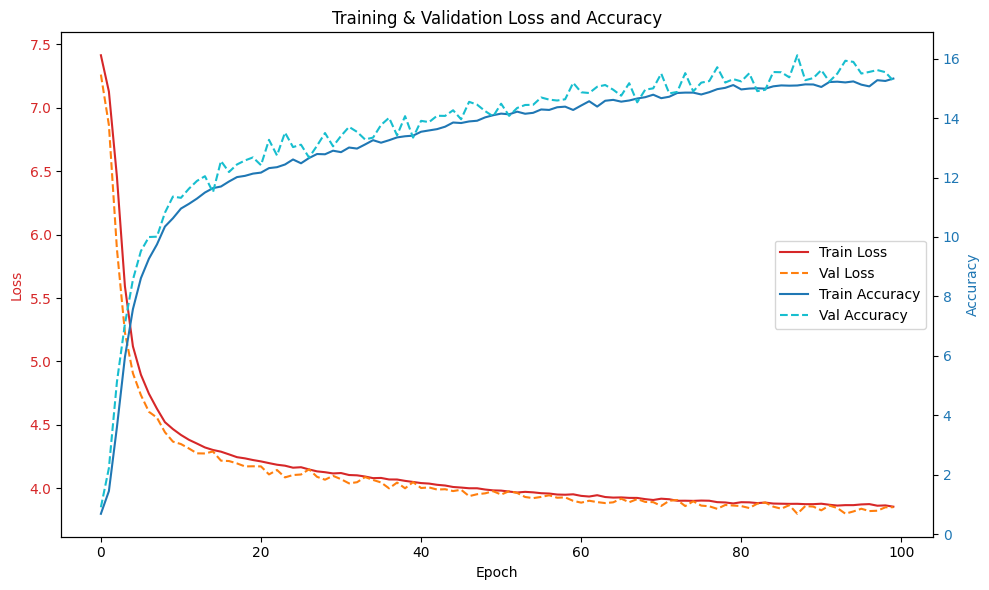

In [ ]:
train_loss = [entry["loss"].detach().cpu().numpy() for entry in loss_list]
val_loss = [entry["val_loss"].cpu().numpy() for entry in loss_list]
train_acc = [entry["accuracy"] for entry in loss_list]
val_acc = [entry["val_accuracy"] for entry in loss_list]

# Create figure
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot losses (left y-axis)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color="tab:red")
ax1.plot(range(n_epochs), train_loss, label="Train Loss", color="tab:red", linestyle="-")
ax1.plot(range(n_epochs), val_loss, label="Val Loss", color="tab:orange", linestyle="--")
ax1.tick_params(axis="y", labelcolor="tab:red")

# Second y-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy", color="tab:blue")
ax2.plot(range(n_epochs), train_acc, label="Train Accuracy", color="tab:blue", linestyle="-")
ax2.plot(range(n_epochs), val_acc, label="Val Accuracy", color="tab:cyan", linestyle="--")
ax2.tick_params(axis="y", labelcolor="tab:blue")

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="center right")

plt.title("Training & Validation Loss and Accuracy")
plt.tight_layout()
plt.show()

## Sample

### Init & Load Models

In [ ]:
transformer = GPTDecoder().to(device)
vq_vae = VQVAE(input_emb_width=1, output_emb_width=64, k_bins=2048, levels=1, downs_t=[3], strides_t=[2]).to(device)

In [ ]:
if os.path.exists(full_model_path):
    model = torch.load(full_model_path, map_location=device)
    transformer.load_state_dict(model["transformer"])
    logger.info(f"Model {model_name} loaded with {count_parameters(transformer)} Parameters")
if os.path.exists(vq_vae_path):
    model = torch.load(vq_vae_path, map_location=device)
    vq_vae.load_state_dict(model["vq_vae"])
    logger.info(f"Model {vq_vae_name} loaded with {count_parameters(vq_vae)} Parameters")


2025-08-11 12:49:14,694 - INFO - Model transformer_v2_1 loaded with ~22.06M Parameters
2025-08-11 12:49:14,790 - INFO - Model VQ_VAE_v2 loaded with ~597.5k Parameters


### Sampling

In [ ]:
def sample(vq_vae: VQVAE, transformer: GPTDecoder, context: Tensor, device: str = "cpu", temperature: float = 1.0, top_k: (int | None) = 50, total_samples: int = 2 ** 15) -> ndarray:
    vq_vae.eval()
    transformer.eval()
    with torch.no_grad():
        start_time = time.time()
        if context.ndim == 1:
            context = context.unsqueeze(0)
        if context.ndim == 3:
            context = context.squeeze(1)
        sequence = context.to(device)
        while sequence.size(-1) < total_samples:
            logits = transformer(sequence[..., -transformer.max_seq_len:])
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, top_k)
                logits[logits < v[:, [-1]]] = -float('inf')
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            sequence = torch.cat([sequence, next_token], dim=-1)
            dt = time.time() - start_time
            print(f"\rGenerated {sequence.size(-1)}/{total_samples} Samples {int((sequence.size(-1) - context.size(-1)) / dt)} tk/s", end='', flush=True)
        print(flush=True)
        sequence = sequence[..., :total_samples]
        if sequence.ndim == 3:
            sequence = sequence.squeeze(1)
        print(sequence)
        print(context)
        audio = vq_vae.decode(sequence)
        return audio.cpu().numpy()


In [ ]:
def get_dataloader_item(dataloader: DataLoader, idx: int = 0) -> Tensor:
    n = 0
    for x,y in dataloader:
        b_size = x.size(0)
        
        if n + b_size > idx:
            return x[idx - n], y[idx - n]
        n += b_size

In [ ]:
context = latent_test_dataset[:24][0].to(device)
context = context.unsqueeze(1)
print(context.shape)

torch.Size([24, 1, 32768])


In [ ]:
print(context[0])
audio = sample(vq_vae, transformer, context[:10,..., :32700], device, temperature=1, top_k=2)

tensor([[ 530, 1087,  542,  ...,   98, 1137, 1575]], device='cuda:0')
Generated 32712/32768 Samples 4 tk/s

KeyboardInterrupt: 

In [ ]:
idx = 4
n = 1
vq_vae.eval()
inp = test_dataset[:24][0].unsqueeze(1).to(device)
print(inp.shape)
with torch.no_grad():
    output, q_z, commit_loss, metrics = vq_vae(inp)
    outp = vq_vae.decode(q_z)
audio = sample(vq_vae, transformer, q_z[:12,...,:30000], device, temperature=1, top_k=50)


torch.Size([24, 1, 262144])
Generated 32768/32768 Samples 4 tk/s
tensor([[ 878, 1873, 1014,  ...,  602,  724,  368],
        [1467,  751, 1600,  ..., 1858, 1858,  568],
        [ 831, 1067, 1164,  ...,  179, 1317,  169],
        ...,
        [ 746,  247,  451,  ..., 1943,  552, 1182],
        [1171, 1207,  851,  ...,  314, 2000,  618],
        [ 933,  338,  724,  ...,  368,  503, 1182]], device='cuda:0')
tensor([[ 878, 1873, 1014,  ...,  183,  892,  367],
        [1467,  751, 1600,  ..., 1692,  340, 1913],
        [ 831, 1067, 1164,  ..., 1965,  342, 1364],
        ...,
        [ 746,  247,  451,  ...,  727, 1734,  796],
        [1171, 1207,  851,  ..., 1541,  509, 1942],
        [ 933,  338,  724,  ...,  241,  320, 1553]], device='cuda:0')


In [ ]:
data = get_dataloader_item(latent_test_dataloader, 5)[0]
data = data.unsqueeze(0)

Generated 32768/32768 Samples 45 tk/s
tensor([[1160, 1231, 1569,  ...,  526, 1719, 1154]], device='cuda:0')
tensor([[1160, 1231, 1569,  ...,  760,  469,  552]])


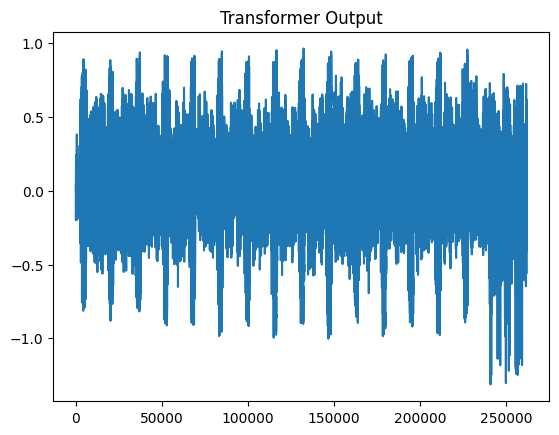

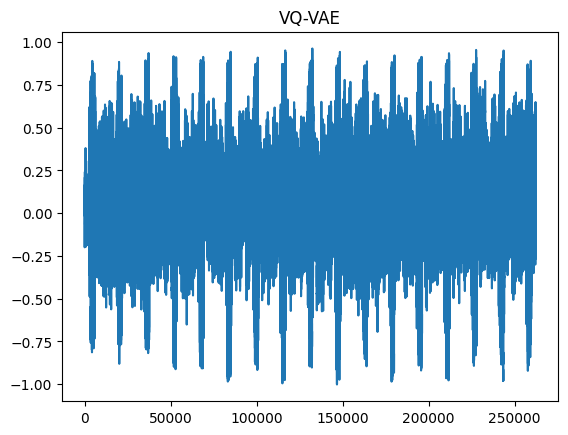

In [ ]:
audio = sample(vq_vae, transformer, data[..., :30000], device, temperature=1, top_k=50)
vq_vae.eval()
with torch.no_grad():
    test = vq_vae.decode([data.to(device)])
plt.plot(audio[0][0])
plt.title("Transformer Output")
plt.show()
plt.plot(test[0][0].cpu().numpy())
plt.title("VQ-VAE")
plt.show()

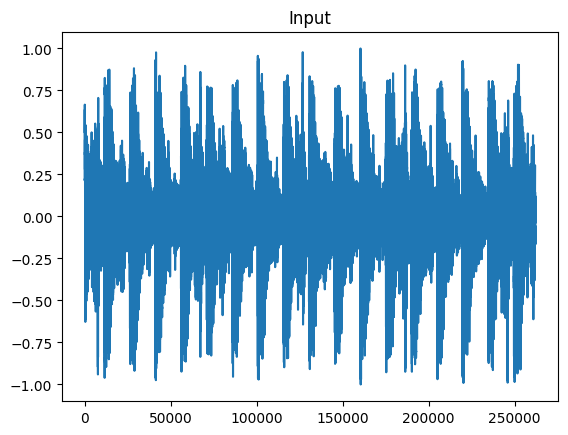

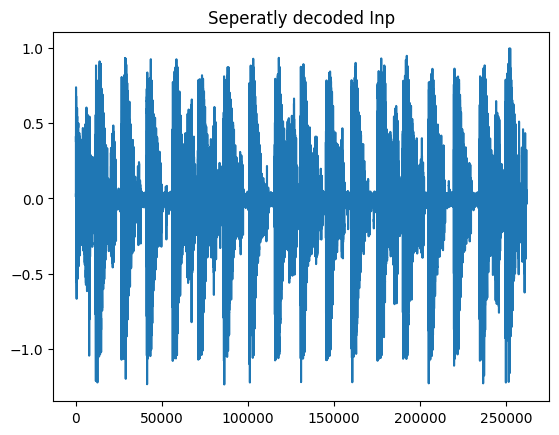

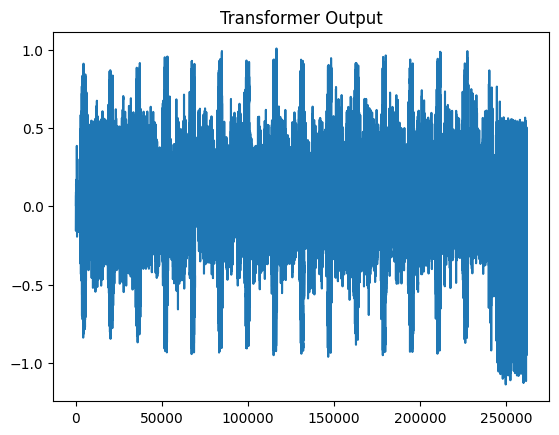

In [ ]:
plt.plot(inp[idx][0].cpu().numpy())
plt.title("Input")
plt.show()
plt.plot(output[idx][0].cpu().numpy())
plt.title("Seperatly decoded Inp")
plt.show()
plt.plot(audio[5][0])
plt.title("Transformer Output")
plt.show()

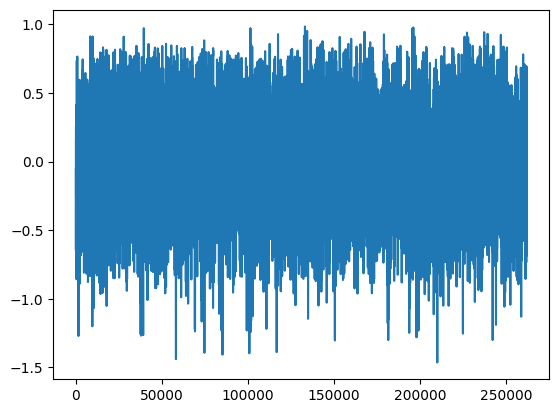

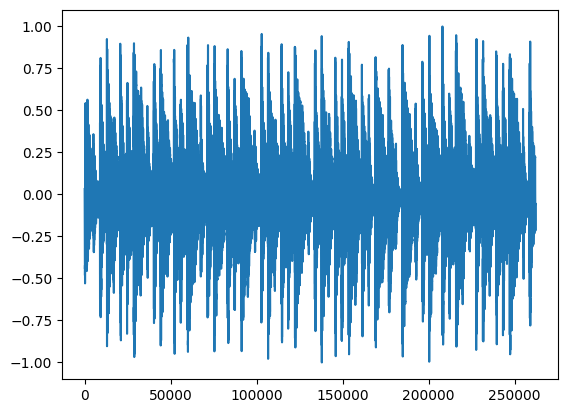

In [ ]:
idx = 0
plt.plot(audio[idx][0])
plt.show()
plt.plot(get_dataloader_item(test_dataloader, idx)[0])
plt.show()

In [ ]:
AudioData(data = audio[4][0]).save_audio_file("Results/Jukebox_test5.wav")